# Segment Anything in TensorFlow

This notebook demonstrates how to use the Segment Anything model in TensorFlow.

It includes:

- Porting weights of the PyTorch model to the Tensorflow model.
- Using the TensorFlow port of the predictor model to extract masks from a given image and prompt.

### TODOs

- Ian: Port the `ResizeLongestSide.apply_image` method to TensorFlow with support for `uint8` images (or maybe don't, we can just use PIL/OpenCV or something).
- Tirth: Saving model or model weights doesn't work after porting them. I think this might be because I don't define `get/set_config` methods... But I think, for the time being, we can let the weight porting script run everything we want to run the demo since it doesn't take very long.
- Tirth: Port the model to Keras Core.
- Tirth: Benchmark the model against the PyTorch model.

In [1]:
%%capture
pip install git+https://github.com/facebookresearch/segment-anything.git

In [2]:
%%shell
git clone https://github.com/tirthasheshpatel/segment_anything_tensorflow.git
mkdir -p sam_tf
mv -f segment_anything_tensorflow/sam_tf/* sam_tf/
mv -f segment_anything_tensorflow/weights_porter.py  ./

Cloning into 'segment_anything_tensorflow'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 74 (delta 41), reused 61 (delta 28), pack-reused 0
Receiving objects: 100% (74/74), 20.98 KiB | 10.49 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [3]:
# Get the image for the demo
!curl -sSL https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg -o truck.jpg

In [4]:
# Get the huge PyTorch model weights
!curl -sSL https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -o sam_vit_h_4b8939.pth

In [5]:
import sys
import json
import glob
from pprint import pprint
import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools import mask as mask_utils

# torch model
import torch
from segment_anything.build_sam import build_sam_vit_b, build_sam_vit_l, build_sam_vit_h
from segment_anything.modeling import ImageEncoderViT, PromptEncoder, MaskDecoder, Sam
from segment_anything import sam_model_registry, SamPredictor

# tensorflow model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from sam_tf.image_encoder import ImageEncoder
from sam_tf.prompt_encoder import PromptEncoder
from sam_tf.mask_decoder import MaskDecoder, TwoWayTransformer
from sam_tf.sam import SegmentAnythingModel
from weights_porter import port_weights_huge

In [6]:
# Define the huge model in TensorFlow

image_encoder = ImageEncoder(
    img_size=1024,
    patch_size=16,
    in_chans=3,
    embed_dim=1280,
    depth=32,
    mlp_dim=1280*4,
    num_heads=16,
    out_chans=256,
    use_bias=True,
    use_rel_pos=True,
    window_size=14,
    global_attention_indices=[7, 15, 23, 31]
)

prompt_encoder = PromptEncoder(
    embed_dim=256,
    image_embedding_size=(64, 64),
    input_image_size=(1024, 1024),
    mask_in_chans=16
)

mask_decoder = MaskDecoder(
    transformer_dim=256,
    transformer=TwoWayTransformer(
        depth=2,
        embedding_dim=256,
        mlp_dim=2048,
        num_heads=8
    ),
    num_multimask_outputs=3,
    iou_head_depth=3,
    iou_head_hidden_dim=256
)

In [7]:
# Forward Pass to build the model

x = tf.ones((1, 1024, 1024, 3))
x_embeddings = image_encoder(x)

points = tf.convert_to_tensor(
    np.random.randint(0, 1023, (7, 10, 2)),
    dtype=tf.float32
)
labels = tf.convert_to_tensor(
    1 * (np.random.rand(7, 10) > 0.5),
    dtype=tf.int64
)
box = tf.constant(
    [[[[10, 10], [500, 500]],
      [[20, 20], [500, 500]],
      [[30, 30], [500, 500]],
      [[40, 40], [500, 500]],
      [[50, 50], [500, 500]],
      [[60, 60], [500, 500]],
      [[70, 70], [500, 500]]]],
    dtype=tf.float32
)
mask = tf.convert_to_tensor(
    1. * (np.random.rand(7, 256, 256, 1) > 0.5),
    dtype=tf.float32
)

sparse_embeddings, dense_embeddings = prompt_encoder(
    points=points,
    labels=labels,
    box=box,
    mask=mask
)

masks_pred, iou_pred = mask_decoder(
    image_embeddings=x_embeddings,
    image_pe=prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings[:1, ...],
    dense_prompt_embeddings=dense_embeddings[:1, ...],
    multimask_output=True
)

In [8]:
model = SegmentAnythingModel(image_encoder, prompt_encoder, mask_decoder)

In [9]:
# We create a predictor to port the weights from PyTorch to TensorFlow

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to("cuda")

predictor = SamPredictor(sam)

In [10]:
# Port the PyTorch model's weights to the TensorFlow model
port_weights_huge(model, predictor.model)

In [11]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [12]:
image = cv2.imread('truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

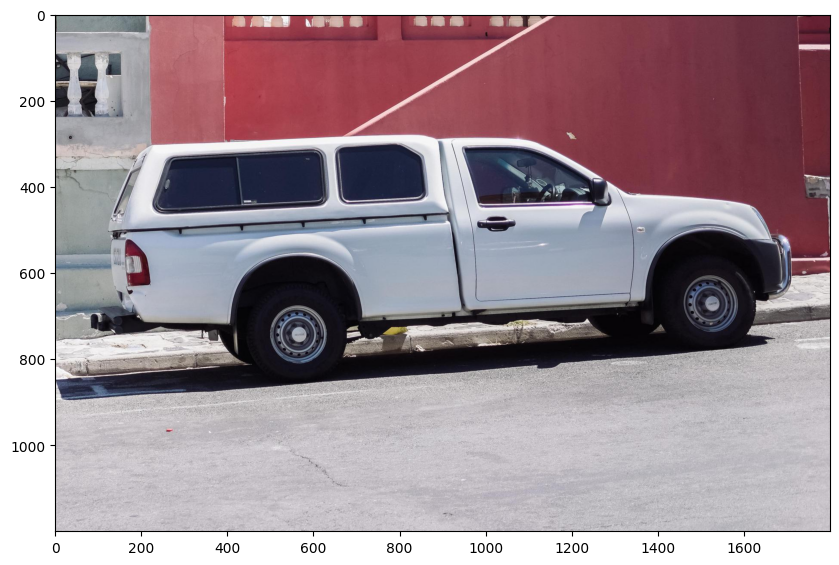

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [14]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

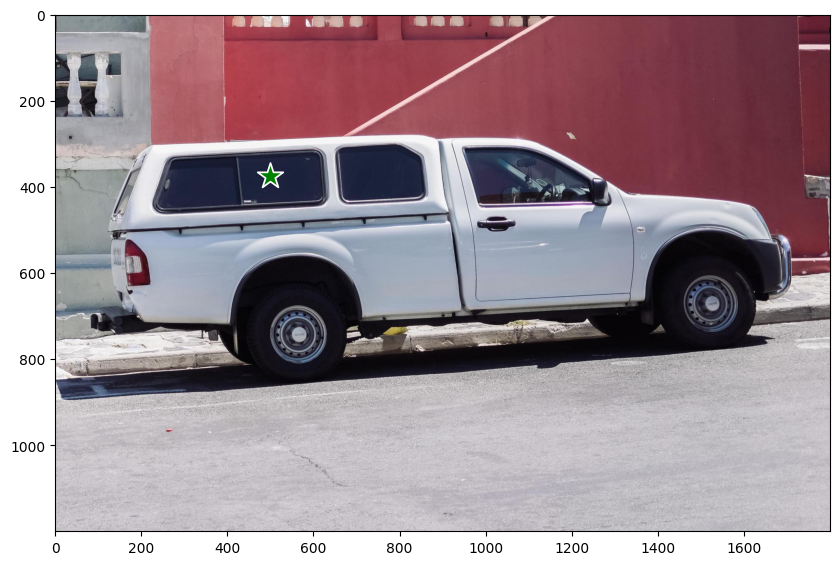

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [16]:
# Re-implementation of https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/utils/transforms.py#L16 in TensorFlow
class ResizeLongestSide:
    def __init__(self, target_length):
        self.target_length = target_length

    def apply_image(self, image):
        target_size = self.get_preprocess_shape(image.shape[1], image.shape[2])
        return tf.image.resize(
            image, size=target_size, method="bilinear"
        )

    def apply_coords(self, coords, original_size):
        old_h, old_w = original_size
        new_h, new_w = self.get_preprocess_shape(original_size[0], original_size[1])
        coords = tf.cast(coords, tf.float32)
        coords_x = coords[..., 0] * (new_w / old_w)
        coords_y = coords[..., 1] * (new_h / old_h)
        return tf.stack([coords_x, coords_y], axis=-1)

    def apply_boxes(self, boxes, original_size):
        boxes = self.apply_coords(
            tf.reshape(
                boxes, shape=(-1, 2, 2)
            ),
            original_size
        )
        return boxes

    def get_preprocess_shape(self, old_h, old_w):
        scale = self.target_length * 1.0 / max(old_h, old_w)
        new_h = old_h * scale
        new_w = old_w * scale
        return int(new_h + 0.5), int(new_w + 0.5)

In [17]:
transform  = ResizeLongestSide(1024)

In [18]:
image_record = {}

# TODO(ianstenbit) -- torchvision.transforms.functional.resize allows uint8 images but I can't find anything equivalent in TensorFlow.
# Temporarily using the PyTorch resize transform to make sure the image is numerically equal to the PyTorch model.
image_record["image"] = tf.convert_to_tensor(predictor.transform.apply_image(image)[np.newaxis, ...], dtype=tf.float32)

image_record["original_size"] = (image.shape[0], image.shape[1])

image_record["point_coords"] = tf.reshape(
    tf.convert_to_tensor(
        input_point, dtype=tf.float32
    ),
    shape=(1, 1, 2)
)
image_record["point_coords"] = transform.apply_coords(
    image_record["point_coords"], image_record["original_size"]
)

image_record["point_labels"] = tf.ones(
    shape=image_record["point_coords"].shape[:-1],
    dtype=tf.float32
)

# Use the code below for box prompts
# image_record["boxes"] = tf.reshape(
#     tf.convert_to_tensor(
#         your_bbox, dtype=tf.float32
#     ),
#     shape=(1, 4)
# )
# image_record["boxes"] = tf.concat(
#     [image_record["boxes"][..., :2],
#       image_record["boxes"][..., :2] + image_record["boxes"][..., 2:]],
#     axis=1
# )
# image_record["boxes"] = transform.apply_boxes(
#     image_record["boxes"], image_record["original_size"]
# )

In [19]:
out = model([image_record])

In [20]:
logits, scores = out[0]["masks"], out[0]["iou_predictions"]

In [21]:
masks = tf.cast(logits > 0.0, dtype=tf.float32)

In [22]:
masks, scores, logits = masks.numpy()[0], scores.numpy()[0], logits.numpy()

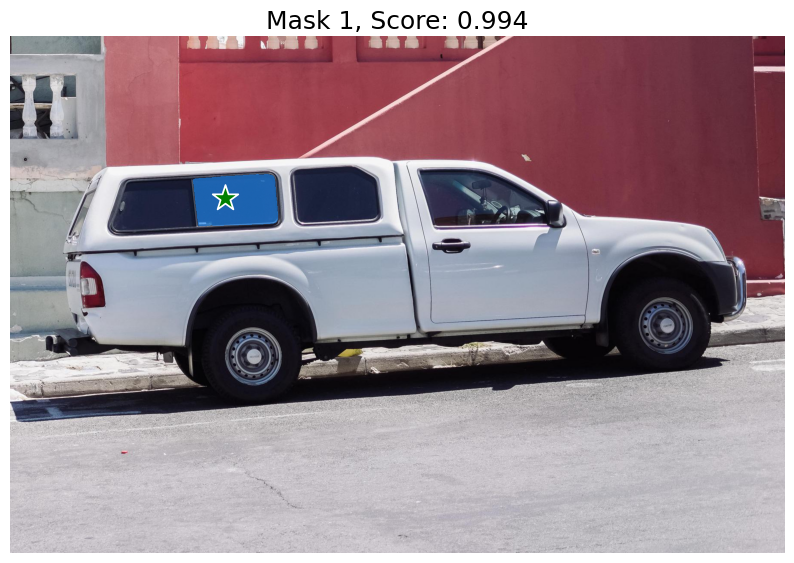

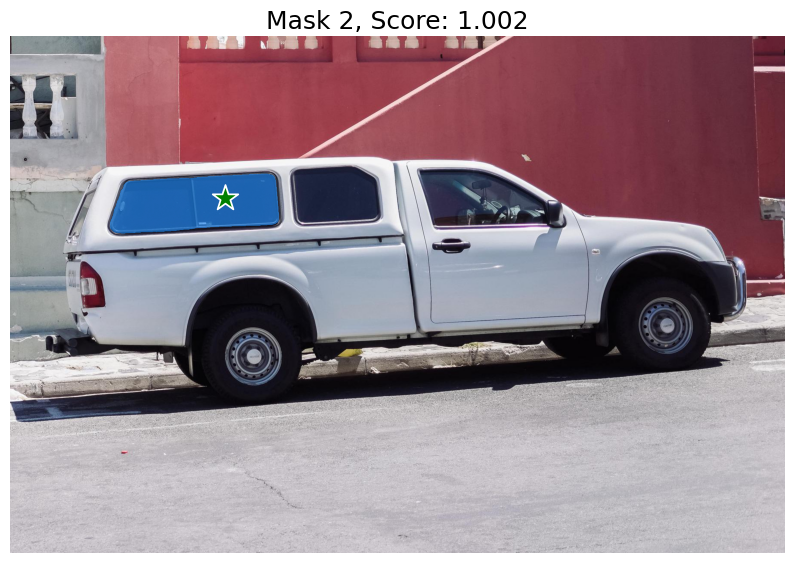

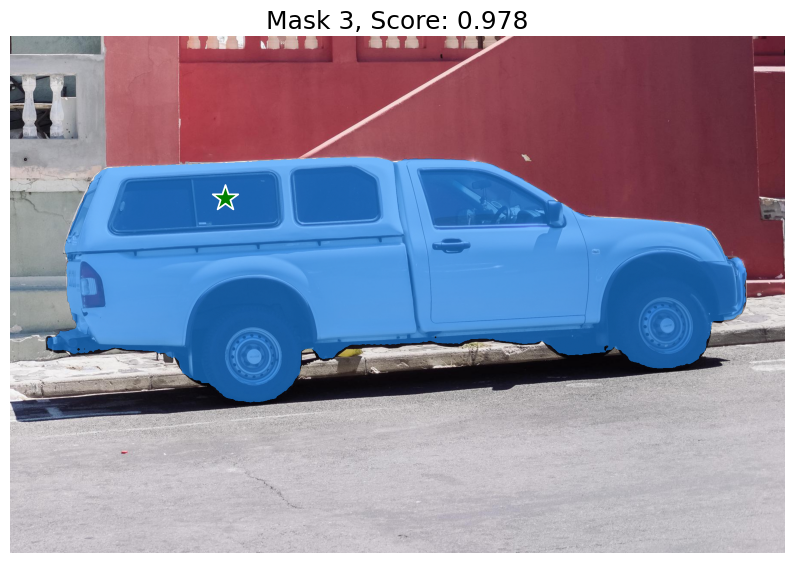

In [23]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

# [WIP] Benchmarks

In [24]:
# Benchmark the TensorFlow model against the PyTorch model on CPU.
# Looks like they both perform pretty similar...

In [25]:
%%time
out = model([image_record])

CPU times: user 3min 35s, sys: 35.6 s, total: 4min 11s
Wall time: 39.9 s


In [26]:
%%time
out = predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

CPU times: user 1min 57s, sys: 22.3 s, total: 2min 19s
Wall time: 35.8 s
